<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Video-in-Notebooks" data-toc-modified-id="Video-in-Notebooks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Video in Notebooks</a></span></li><li><span><a href="#Normalized-Sum-of-Squared-Differences-and-Normalized-Cross-Correlation" data-toc-modified-id="Normalized-Sum-of-Squared-Differences-and-Normalized-Cross-Correlation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Normalized Sum of Squared Differences and Normalized Cross Correlation</a></span><ul class="toc-item"><li><span><a href="#Sum-of-Squared-Differences" data-toc-modified-id="Sum-of-Squared-Differences-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Sum of Squared Differences</a></span></li><li><span><a href="#Normalized-Sum-of-Squared-Distances" data-toc-modified-id="Normalized-Sum-of-Squared-Distances-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Normalized Sum of Squared Distances</a></span></li><li><span><a href="#Normalized-Cross-Correlation" data-toc-modified-id="Normalized-Cross-Correlation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Normalized Cross Correlation</a></span></li><li><span><a href="#Faster-Normalized-Cross-Correlation-in-Python" data-toc-modified-id="Faster-Normalized-Cross-Correlation-in-Python-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Faster Normalized Cross Correlation in Python</a></span></li><li><span><a href="#Template-Matching" data-toc-modified-id="Template-Matching-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Template Matching</a></span></li></ul></li><li><span><a href="#Correlation-based-Tracking" data-toc-modified-id="Correlation-based-Tracking-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Correlation based Tracking</a></span><ul class="toc-item"><li><span><a href="#Tracking-the-Ball" data-toc-modified-id="Tracking-the-Ball-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Tracking the Ball</a></span></li><li><span><a href="#(BONUS)-Speeding-Up-Correlation-based-Tracking" data-toc-modified-id="(BONUS)-Speeding-Up-Correlation-based-Tracking-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>(BONUS) Speeding Up Correlation based Tracking</a></span></li><li><span><a href="#Simulating-an-Optical-Mouse" data-toc-modified-id="Simulating-an-Optical-Mouse-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Simulating an Optical Mouse</a></span></li></ul></li><li><span><a href="#Some-Final-Notes-on-Tracking" data-toc-modified-id="Some-Final-Notes-on-Tracking-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Some Final Notes on Tracking</a></span></li></ul></div>

# CV LabExercise: Image Motion

## 1. Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
from os.path import isfile
import wget
import imageio
from pprint import pprint
from scipy.ndimage import gaussian_filter, generic_filter, uniform_filter, correlate
from skimage.feature import match_template
from skimage.color import rgb2gray


Hidden in this cell are some $\LaTeX$ macros
$\newcommand{\v}[1]{\mathbf #1}$
$\newcommand{\hv}[1]{\widetilde{\mathbf #1}}$
$\newcommand{\setR}{\mathbb R}$
$\newcommand{\set}[1]{\mathcal #1}$
$\newcommand{\T}{^\top}$
$\newcommand{\inv}{^{-1}}$
$\newcommand{\pfrac}[2]{\frac{\partial #1}{\partial #2}}$
$\DeclareMathOperator{\ssd}{ssd}$
$\DeclareMathOperator{\nssd}{nssd}$
$\DeclareMathOperator{\ncc}{ncc}$
$\newcommand{\one}{\mathbb{I}}$
$\DeclareMathOperator{\nom}{nom}$
$\DeclareMathOperator{\den}{den}$


## 2. Utilities

In [3]:
def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)

## 3. Video in Notebooks

Given the url of a video file you can play it in a Jupyter notebook:

In [4]:
url = "https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/ball2.mp4"
Video(url)

When processing video we will need to be able to access the individual frames (images) in a video. To do so we will first download the video shown above to your local directory:

In [7]:
if not isfile("ball2.mp4"):
    print("Downloading the video")
    wget.download(url)

To read mp4 files we will use the ``imageio`` package. You may need to install this package: specifically the package `imagio-ffmpeg`, which you can install with pip. Depending on your operating system you may also need to explicitly install ffmpeg itself; e.g. on Ubuntu you might use `sudo apt install ffmpeg`. 

In [8]:
reader = imageio.get_reader("ball2.mp4")

With the reader we can access the individual frames in the video. Below we retrieve every other 4 frames from the video starting at frame 40 (before that little is seen). Please note that we must set an interactive backend to do updates in a plot. Below i have chosen for the ``notebook`` backend. Please do not forget to switch to the ``inline`` backend after you have run the code (but not in the same cell!).

<IPython.core.display.Javascript object>


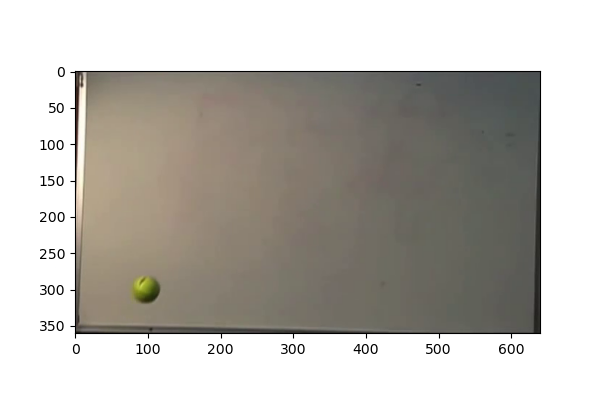

In [9]:
%matplotlib notebook
no_frames = reader.count_frames()
start_frame = 40
step_frame = 4
stop_frame = no_frames

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
im = reader.get_data(start_frame)
img = ax.imshow(im)
fig.canvas.draw()



for i in range(start_frame, start_frame+1, step_frame):
    im = reader.get_data(i)
    img.set_data(im)
    
    ## here you can do some processing of the incoming frames
    ## and possibly do some drawing
    
    fig.canvas.draw();
    

In [10]:
%matplotlib inline

## 4. Normalized Sum of Squared Differences and Normalized Cross Correlation 

We start with a simple image: Gaussian filtered noise. And we select a small detail of size 32x32 as the image we would like to find with a correlation based method. In the figure below the detail to be found (and fixed in position) is outlined in red in the orginal image. A detail at some other position is outlined in blue. Both details are also shown.

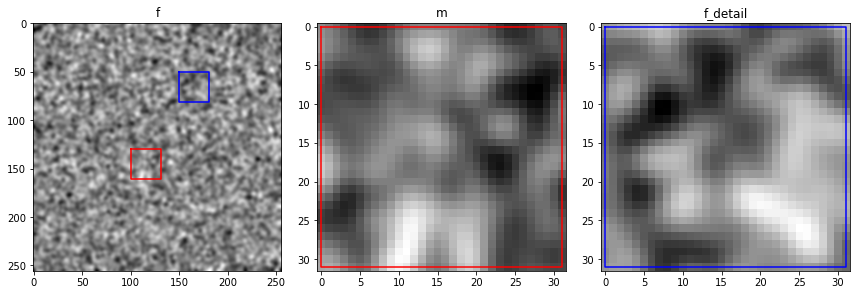

In [11]:
np.random.seed(378235)
f = gaussian_filter(np.random.randn(256, 256), 2)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(f)
plt.gray()
plt.title('f')
x, y = 100, 130
size = 32
plt.plot( [x, x+size-1, x+size-1, x, x], [y, y, y+size-1, y+size-1, y], '-r')
xr, yr = 150, 50
plt.plot( [xr, xr+size-1, xr+size-1, xr, xr], [yr, yr, yr+size-1, yr+size-1, yr], '-b')

plt.subplot(132)
m = f[y:y+size, x:x+size]
plt.imshow(m);
plt.plot( [0, size-1, size-1, 0, 0], [0, 0, size-1, size-1, 0], '-r')
plt.title('m')

plt.subplot(133)
f_detail = f[yr:yr+size, xr:xr+size]
plt.imshow(f_detail);
plt.plot( [0, size-1, size-1, 0, 0], [0, 0, size-1, size-1, 0], '-b')
plt.title('f_detail')

plt.tight_layout();

### 4.1 Sum of Squared Differences

Next you have to calculate the sum of squared differences of the template ``m`` and detail ``f_detail``. Because we are going to use the ``generic_filter`` function to calculate the ssd for each shifted version of ``f_detail`` we need to write the function ``calculate_ssd`` to have the flattened arrays as input (i.e. the array reshaped in one dimensional array). (3pt)

In [12]:
def calculate_ssd(f_detail_flattened, m_flattened):
    """return the sum of squared distances for the two arguments"""
    length = len(m_flattened)
    error = np.mean(np.sum((f_detail_flattened - m_flattened)**2))
    return error/length

In [13]:
v1 = v2 = np.random.normal(0, 1, 10)
assert np.isclose(calculate_ssd(v1, v2), 0.0)

v1 = np.arange(5)
v2 = np.zeros(5)
assert np.isclose(calculate_ssd(v1, v2), 6)

x, y = 100, 130
size = 32
xr, yr = 150, 50
m = f[y:y+size, x:x+size]
f_detail = f[yr:yr+size, xr:xr+size]

assert np.allclose(calculate_ssd(f_detail.flatten(), m.flatten()), 58.4205 / 32**2)
assert np.allclose(calculate_ssd(m.flatten(), m.flatten()), 0)


Next we can use the ``generic_filter`` function to calculate the ssd for each translated version of ``f_detail`` and fixed template ``m``. 

116 146


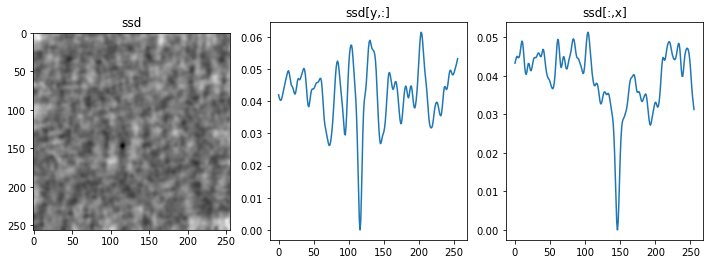

In [14]:
ssd = generic_filter(f, calculate_ssd, 32, extra_arguments=(m.flatten(),))
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(ssd)
plt.title('ssd')
y, x = np.unravel_index(np.argmin(ssd), ssd.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(ssd[y])
plt.title('ssd[y,:]')
plt.subplot(133)
plt.plot(ssd[:,x])
plt.title('ssd[:,x]');

In case you were expecting the minimal value to be at (100, 130) remember that the ``generic_filter`` considers neighborhoods centered in the middle of the template (i.e. at position (16, 16) of the 32x32 image details we are looking at. So the minimum at (116, 146) is consistent with our choice of the square neighborhood with top left corner at (100, 130).

### 4.2 Normalized Sum of Squared Distances

Next write the function ``calculate_nssd`` to calculate the normalized sum of squared distances. (3pt)

In [15]:
def calculate_nssd(f_detail_flattened, m_flattened):
    f_mean = np.mean(f_detail_flattened)
    m_mean = np.mean(m_flattened)
    
    s_f = np.sqrt(np.mean((f_detail_flattened - f_mean)**2))
    m_f = np.sqrt(np.mean((m_flattened - m_mean)**2))
    
    f_hat = (f_detail_flattened - f_mean)/s_f
    m_hat = (m_flattened - m_mean)/m_f
    
    return calculate_ssd(f_hat, m_hat)


In [16]:
v1 = v2 = np.random.normal(3, 2, 10)
assert np.isclose(calculate_nssd(v1, v2), 0.0)

v1 = np.arange(5)
v2 = np.array([1,2,1,2,1])
assert np.isclose(calculate_nssd(v1, v2), 2.0)

x, y = 100, 130
size = 32
xr, yr = 150, 50
m = f[y:y+size, x:x+size]
f_detail = f[yr:yr+size, xr:xr+size]

assert np.allclose(calculate_nssd(f_detail.flatten(), m.flatten()), 2.267358173713738)


116 146


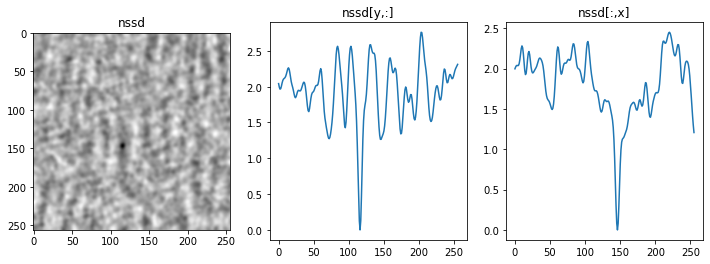

In [17]:
# This cell takes some time to run... (about 10 seconds on my computer)
nssd = generic_filter(f, calculate_nssd, 32, extra_arguments=(m.flatten(),))
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(nssd)
plt.title('nssd')
y, x = np.unravel_index(np.argmin(nssd), nssd.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(nssd[y])
plt.title('nssd[y,:]')
plt.subplot(133)
plt.plot(nssd[:,x])
plt.title('nssd[:,x]');

### 4.3 Normalized Cross Correlation

Write the function `calculate_ncc`, to calculate the normalized cross correlation of two sequences. (3pt)

In [18]:
def calculate_ncc(f_detail_flattened, m_flattened):
    f_mean = np.mean(f_detail_flattened)
    m_mean = np.mean(m_flattened)
    
    s_f = np.sqrt(np.mean((f_detail_flattened - f_mean)**2))
    m_f = np.sqrt(np.mean((m_flattened - m_mean)**2))
    
    f_hat = (f_detail_flattened - f_mean)/s_f
    m_hat = (m_flattened - m_mean)/m_f
    
    return np.mean(f_hat*m_hat)

In [19]:
v1 = v2 = np.random.normal(3, 2, 10)
assert np.isclose(calculate_ncc(v1, v2), 1.0)

v1 = np.arange(5)
v2 = np.array([1,2,1,2,1])
assert np.isclose(calculate_ncc(v1, v2), 0.0)

x, y = 100, 130
size = 32
xr, yr = 150, 50
m = f[y:y+size, x:x+size]
f_detail = f[yr:yr+size, xr:xr+size]

assert np.allclose(calculate_ncc(f_detail.flatten(), m.flatten()), -0.1336790868568689)


116 146


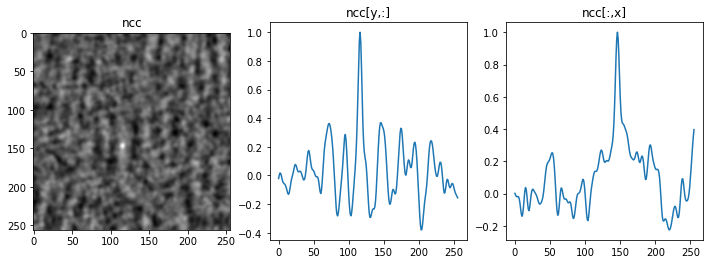

In [20]:
ncc = generic_filter(f, calculate_ncc, 32, extra_arguments=(m.flatten(),))
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(ncc)
plt.title('ncc')
y, x = np.unravel_index(np.argmax(ncc), ncc.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(ncc[y])
plt.title('ncc[y,:]')
plt.subplot(133)
plt.plot(ncc[:,x])
plt.title('ncc[:,x]');

In the lecture notes it is derived that:
\begin{align}
\mbox{nssd} = 2 ( 1 - \mbox{ncc})
\end{align}
Let's test that:

In [21]:
np.allclose(nssd, 2*(1-ncc))

True

### 4.4 Faster Normalized Cross Correlation in Python

The normalized cross correlation is quite slow. In the lecture notes the derivation is given leading to the following recipe to calculate the ncc using convolutions:

1. Normalize the mask, i.e. subtract the mean and divide by the
   standard deviation:
   \begin{align} 
      \hat m(\v x) = \frac{m(\v x) - \bar m}{s_m}
   \end{align}

1. Let $f$ be the image where to search for the mask. Calculate the
   following convolutions:
   \begin{align} 
      \nom &= f \ast \hat m^\star \\
      \den_1 &= M^2\;f^2 \ast [\set M]^\star \\
      \den_2 &= M\;f \ast [\set M]^\star \\
   \end{align} 
   
1. Calculate the ncc image:
   \begin{align}
      ncc = \frac{\nom}{\sqrt{\den_1-\den_2^2}}
   \end{align}

1. Find the position $\v x^\star$ where $\ncc$ is maximal
   \begin{align}
       \v x^\star = \arg\max_{\v x} \ncc(\v x)
   \end{align}
  
Write the function `ncc_filter`, which computes the normalized cross-correlation much faster using convolutions (use the function `uniform_filter`). (3pt)

In [22]:
def ncc_filter(f, m):
    m_mean = np.mean(m)
    m_f = np.sqrt(np.mean((m - m_mean)**2))
    m_hat = (m - m_mean)/m_f
    M = len(m.flatten())
    
    nom = correlate(f, m_hat)
    den1 = uniform_filter((f**2 * M**2), m.shape)
    den2 = uniform_filter((f * M), m.shape)
    
    return nom/np.sqrt(den1 - den2**2)
    

In [23]:
f_test = np.random.normal(2, 3, (256, 256))
m_test = np.random.normal(-1, 2, (32, 32))
test_ncc = generic_filter(f_test, calculate_ncc, 32, extra_arguments=(m_test.flatten(),))
test_fncc = ncc_filter(f_test, m_test)
assert np.allclose(test_ncc, test_fncc), "The output of your ncc_filter does not match that of calculate_ncc."


116 146


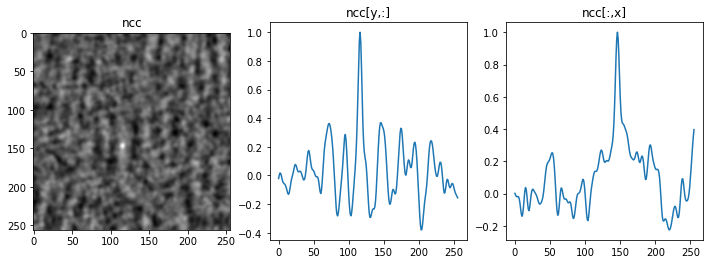

In [24]:
fncc = ncc_filter(f, m)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(fncc)
plt.title('ncc')
y, x = np.unravel_index(np.argmax(fncc), fncc.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(fncc[y])
plt.title('ncc[y,:]')
plt.subplot(133)
plt.plot(fncc[:,x])
plt.title('ncc[:,x]');

In [25]:
# Check that your two methods give the same answer for the image we are working with.
assert np.allclose(ncc, fncc)
assert x==116
assert y==146

### 4.5 Template Matching

The normalized cross correlation that you have developed in this exercise is known in Scikit Image (skimage) as ``match_template``.

116 146


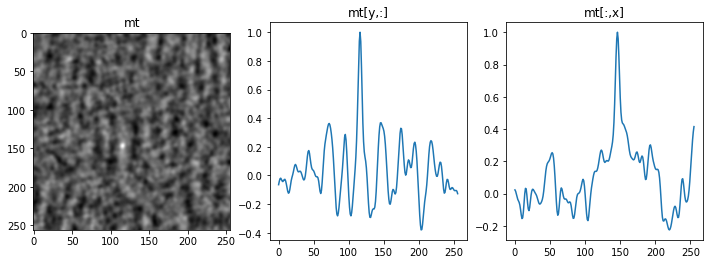

In [26]:
mt = match_template(f, m, pad_input=True, mode='reflect')
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(mt)
plt.title('mt')
y, x = np.unravel_index(np.argmax(mt), mt.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(mt[y])
plt.title('mt[y,:]')
plt.subplot(133)
plt.plot(mt[:,x])
plt.title('mt[:,x]');

In [27]:
np.allclose(fncc,mt) 
# for this to return True you have to set the named 
# argument ``mode='constant'`` both for the match_template function as 
# well as for the ``correlate`` and ``uniform_filter`` in the ``ncc_filter`` function.
# Looking at the difference image it is clear that it is a border problem!

False

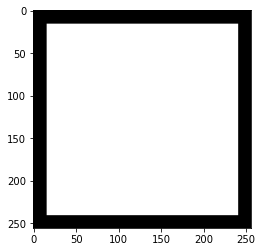

In [28]:
plt.imshow(abs(fncc-mt)<0.000000001); # to illustrate where the 'errors' are

## 5. Correlation based Tracking

### 5.1 Tracking the Ball

Remember the code to display a video file frame by frame? You finally have to use that code here and adapt it to:

1. Select a template in the starting frame (index ``start_frame``).

1. From the starting frame to the end (index ``stop_frame``) you have to find the ball with your own ``ncc_filter`` or with the ``match_template`` function from skimage.

1. While the animation is running you should display the outline of the matched detail on top of each frame.

1. The end result should be a plot with the original start frame showing and on top of that markers indicating the 
   path of the ball over all frames. Thus there should be a parabola of markers across the original image.
   
This assignment is worth 8 points.
   
Hints: 

1. Start by using the ``match_template`` function (it is much faster)

1. the normalized cross correlation is defined for gray value images. Use the function 
   ``skimage.color.rgb2gray`` to convert a color image to a gray scale image.

1. Look at the code at the start of section 4 to see an easy way to draw the outlines.

1. At the end of the video the ball has disappeared from view. If you keep looking for it, you will likely find 'random' locations in the image. Can you detect when the ball has disappeared and stop drawing frames 'at random'?

<IPython.core.display.Javascript object>


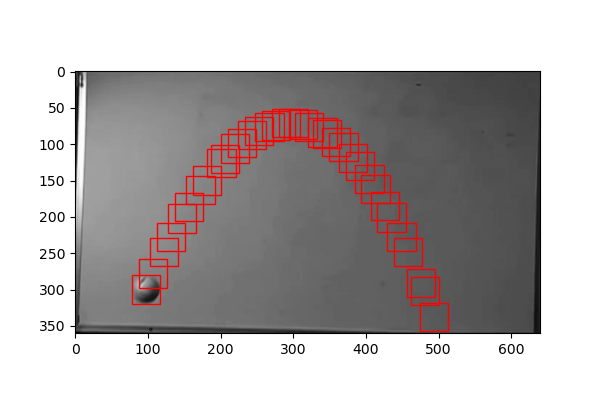

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib notebook
no_frames = reader.count_frames()
start_frame = 40
step_frame = 10 # at least for testing start with steps of 10
stop_frame = no_frames

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
im = reader.get_data(start_frame)
img = ax.imshow(im)

## In this block of code, do all the initialization for the tracking.
## Also draw the template outline on top of the starting frame, so that we
## can see what template you are using to search.
x, y = 78, 281
size = 39

start = reader.get_data(start_frame)
gray = rgb2gray(start)

m = gray[y:y+size, x:x+size]

fig.canvas.draw()
plt.pause(2) # pause 2 seconds to see your choice of starting position of the template

trajectory = []
outlines = []

for i in range(start_frame, no_frames, step_frame):
    im = reader.get_data(i)
    img.set_data(im)
    im = rgb2gray(im)
    
    ## In this code block, do the processing of the incoming frames.
    ## In each frame, draw the outline of the location where you have
    ## found your template on top of the image.
    mt = (match_template(im, m, pad_input=True, mode='constant'))
#     fncc = ncc_filter(f, m) uit gezet want mt veel sneller
    y, x = np.unravel_index(np.argmax(mt), mt.shape[:2])
    curr = len(trajectory)
    
    # check for outliers
    if curr > 0:
        if abs(y - trajectory[curr-1][1]) > 50 or abs(x - trajectory[curr-1][0]) > 50:
            continue
    trajectory.append((x,y))
    
    # draw squares
    
    sq = patches.Rectangle(((x-0.5*size, y-0.5*size)),size,size,linewidth=1,edgecolor='r',facecolor='none')
    outlines.append(sq)
    fig.canvas.draw();
    ax.add_patch(sq)

    
    
## Finally, draw the final "summary" image: the starting frame with markers at all the locations
## where you found the ball on top. (That is, the markers should show the trajectory of the ball.)
im = gray
img.set_data(im)
ax.imshow(im)
fig.canvas.draw();
for sq in outlines:
    ax.add_patch(sq)
img = ax.imshow(im)


In [30]:
%matplotlib inline

### 5.2 (BONUS) Speeding Up Correlation based Tracking

Note: before you start working on the bonus part in this section you are advised to first finish all obligatory sections (like the next one).

We were not really *tracking* the ball. We were *finding* the ball in every frame, over and over again we did brute force searching for the ball in all positions in the image. Note that this is not so uncommon, even the most advanced deep learning systems do not have a built in notion of movement. A ball visible in frame at time $t$ will not pop up at a completely different position in frame at time $t+1$.

In the first frame, the ball position and size were given (that is, we hardcoded its location). Then, in the second frame, we searched for the ball in the entire image. But we could use a priori knowledge that the ball is moving at a maximal speed (in pixels) of, say, 100 pixels per frame. Then, given starting position $\v x_0$, we have to search only at those positions $\v x$ such that $\|\v x - \v x_0\|<100$. Assuming a standard Euclidean norm measure that would result in a circular search area. A more appropriate norm measure is the uniform or max norm $\|\v x\|_\infty$, defined by $\|\v x\|=\max\{|x_1|, \ldots, |x_n|\}$. This norm has a square "unit circle": the set of points $\v x$ with $\|\v x\|_\infty = 1$ form a square.

Now imagine that we have found the position $\v x_1$ of the ball in the frame at time $t=1$. Then we can estimate the velocity vector at time $t=1$ with $\v v_1 \approx \v x_1 - \v x_0$. So in the frame at time $t=2$ we can search for the ball in the neighborhood $\v x_1 + \v v_1$ (assuming the time difference is 1 between two frames). The size of the neighborhood then should reflect our a priori knowledge of how crude the motion model is and what errors are made and will typically lead to the neighborhood $\|\v x - (\v x_1 + \v v_1)\|_\infty < R$ where $R$ is typically smaller than the 'radius' that we had to use giving only a position and maximal speed (but no direction).

When we are done looking at frame $i$ we have $\v x_i$ and the speed $\v v_i = \v x_i - \v x_{i-1}$ and we can predict where the ball will be in frame $i+1$:
\begin{align}
\v x_{i+1} &\approx \v x_i + \v v_1
\end{align}
We then correct our prediction by looking in the neighborhood of the predicted position where the ball really is (according to the normallized correlation).

Thus incorporating a motion model that can predict where the ball will be in a next frame can decrease the size of the search area. But it doesn't always work in practice. If we had a wider and longer view of the ball and saw it bouncing on the floor, the speed would suddenly change from downward to upward and our simple tracking algorithms would have a hard time tracking the ball.

For this bonus exercise you are asked to implement the ideas described in the text above. In the resuling animation you should not only draw the box around the ball, but also the search area. (4pt)

In case you are really having fun with this and want to learn more you may:

- incorporate the accelaration of the ball in your motion model (and thus prediction)

- look in the literature for *Kalman Filters* that take these ideas to the next (probabilistic) level

### 5.3 Simulating an Optical Mouse

An optical mouse contains a camera that looks at the surface it is moving on. The resolution of the camera is quite low but because of that the frame rate is quite high. Therefore when moving the mouse, frame i and frame i+1 have a significant overlap in the area that is depicted.

The video below shows what a mouse sees when moving over a table surface (this is a simulation!)
https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/mousemovie.mp4

In [31]:
Video("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/mousemovie.mp4", width=256)

In [32]:
if not isfile("mousemovie.mp4"):
    print("Downloading the video")
    wget.download('https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/mousemovie.mp4')

In [33]:
reader = imageio.get_reader("mousemovie.mp4")

Let's look at the same interactive loop to display the video frame by frame (NOTE: the video is a 'color' image, so ``rgb2gray`` is needed),

You have to write a program that calculates what the path is that the mouse travelled. Assume that in the first frame the center of the image is at position $(0,0)$. Pick a subset of the image in frame 0 and use that as a template to look for in frame 1. The position where you found that subset in frame 1 is indicative of the movement of the mouse. Then you select a template in frame 1 and look in frame 2 where it has moved to. Etc, etc.

The result of the video loop should be list of $(dx,dy)$ tuples indicating the movement from frame i to frame i+1.

Assuming a starting position $(0,0)$ you can calculate the list of positions $(x,y)$ for all frames. Make a plot of the path. At every 10th frame you have to plot the frame index at the associated position (this helps us in determining whether you have found the right path).

In this exercise you can either use your own cross correlation template matcher or the one from skimage.

In the end the block of code below should display:

1. The original video, with on every frame super-imposed the outline of the template that you will be using to search in the next frame.
2. A graph of the path that the mouse took: a plot of all (x, y) values past which your mouse travelled. Additionally, at every tenth frame, the plot should also contain at that location the number of frames that have passed.

This assignment is worth 8 points.

<IPython.core.display.Javascript object>


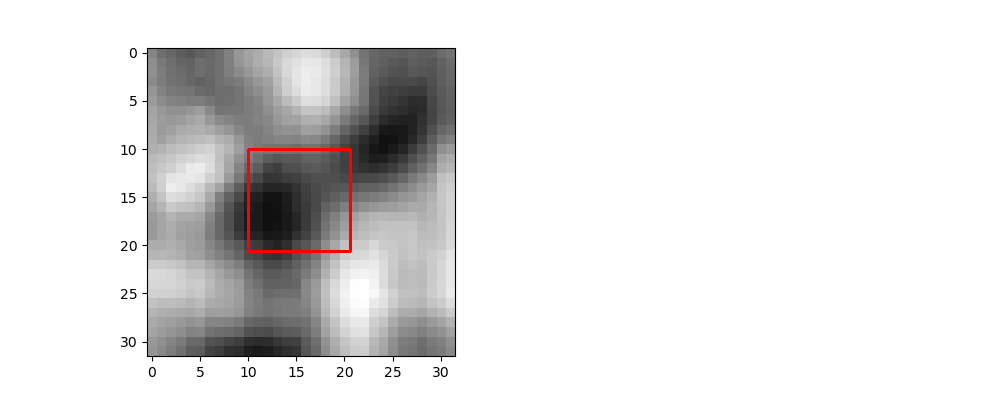

In [34]:
%matplotlib notebook
no_frames = reader.count_frames()
start_frame = 0
step_frame = 1
stop_frame = no_frames

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
im = reader.get_data(start_frame)
img = ax.imshow(im)


## here initialization for the tracking, also draw
## the template outline on top of the starting frame
gray = rgb2gray(im)

size = gray.shape[0]
border = int(0.33 * size)

m = gray[border:size-border,border:size-border]

sq = patches.Rectangle(((border, border)),0.33*size,0.33*size,linewidth=1,edgecolor='r',facecolor='none')
# outlines.append(sq)
fig.canvas.draw();
ax.add_patch(sq)

fig.canvas.draw()
plt.pause(2) # pause 2 seconds to see your choice of starting position of the template

dxdy = []
path = []

for i in range(start_frame, no_frames, step_frame):
    im = reader.get_data(i)
    img.set_data(im)
    im = rgb2gray(im)
    
    ## Process the incoming frames `im`: find the new values to append to dxdy,
    ## and the new template you will use to continue searching.
    
    mt = (match_template(im, m, pad_input=True, mode='constant'))
    y, x = np.unravel_index(np.argmax(mt), mt.shape[:2])
    
    x -= 0.5*size
    y -= 0.5*size
    
    if i == 0:
        path.append((x,y))
    else:
        px = path[i-1][0]
        py = path[i-1][1]
        dy = -y
        dx = -x
        dxdy.append((dx,dy))
        
        path.append((px+dx,py-dy))
    
    sq = patches.Rectangle(((border, border)),0.33*size,0.33*size,linewidth=1,edgecolor='r',facecolor='none')
    fig.canvas.draw();
    ax.add_patch(sq)
    
    m = im[border:size-border,border:size-border]
    
    
    
# Finally, create the plot showing the path taken by the mouse.
plt.subplot(122)
for i in range(start_frame, no_frames, 10):
    x = path[i][0]
    y = path[i][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
plt.show()

In [35]:
%matplotlib inline